# Intrinsic Analysis

This notebook analyses the quality of OSM data for a given area. The purpose of the evaluation is specifically to assess the fitness for use of OSM data for cycling research, particularly research projects based around network analysis, in which the topology of the geometries are of particular importance.

The notebook makes use of quality metrics previously used by a range of previous projects investigating OSM/VGI data quality, such as XXXXXX.

Since the assesment do not make use of an external reference dataset as the 'ground truth', it is hard to make any universal claims about data quality or whether the data is good enough for a particular purpose.

The ambition is instead to highlight issues that might undermine the quality of analyses based on the data, but leaves the final interpretation of the results to the end user.

In [85]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
from src import graph_functions as gf
from src import simplification_functions as sf
from src import evaluation_functions as ef

In [86]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']
    
print('Settings loaded!')

Settings loaded!


**Load OSM graphs and grid:**

*(this data is prepared in the 'load_data' notebook)*

In [87]:
# Load simplified and non-simplified graphs

osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
nodes, edges = ox.graph_to_gdfs(osm_graph)
simplified_nodes, simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Fix converted boolean values
simplified_edges.loc[simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
simplified_edges.loc[simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

edges.loc[edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
edges.loc[edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
simplified_edges['infrastructure_length'] = simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)

# creating coulumns with node id and indexes (required by some functions)
simplified_edges['edge_id'] = simplified_edges.reset_index().index
edges['edge_id'] = edges.reset_index().index

u_list = simplified_edges.reset_index()['u'].to_list()
v_list = simplified_edges.reset_index()['v'].to_list()
simplified_edges['u'] = u_list
simplified_edges['v'] = v_list

u_list = edges.reset_index()['u'].to_list()
v_list = edges.reset_index()['v'].to_list()
edges['u'] = u_list
edges['v'] = v_list

simplified_nodes['node_id'] = simplified_nodes.index
nodes['node_id'] = nodes.index

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

grid_ids = grid.grid_id.to_list()

print('Data loaded!')

Data loaded!


**Joining grid cell id to network elements and counting features in each grid:**

In [88]:
# Join grid ids to data 
s_edges_join = gpd.overlay(simplified_edges, grid, how ='intersection')
edges_join = gpd.overlay(edges, grid, how='intersection')

s_nodes_join = gpd.overlay(simplified_nodes, grid, how ='intersection')
nodes_join = gpd.overlay(nodes, grid, how='intersection')

# Count features in each grid cell
all_data = [edges_join, nodes_join, s_edges_join, s_nodes_join]
labels = ['edges','nodes','simplified_edges','simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how = 'left')

## Simplification & Graph Conversion Outcome

In order to compare the structure and true ratio between nodes and edges in a network, a simplified network representation which only includes nodes at endpoints and intersections are required. The simplification process for this area resulted in the following reduction of network elements:

In [89]:
edge_percent_diff = (len(edges) - len(simplified_edges)) / len(edges)*100
node_percent_diff = (len(nodes) - len(simplified_nodes)) / len(nodes)*100

simplification_results = {
    'edge_percent_diff': edge_percent_diff,
    'node_percent_diff': node_percent_diff
    }

print(f'Simplifying the network decreased the number of edges with {edge_percent_diff:.1f}%')
print(f'Simplifying the network decreased the number of nodes with {node_percent_diff:.1f}%')

Simplifying the network decreased the number of edges with 82.7%
Simplifying the network decreased the number of nodes with 84.8%


## Missing & Incompatible Tags

For cycling research, we are often interested in more information than just the presence of cycling infrastructure.
Data on e.g. the width of the infrastructure, speedlimits, street lights etc. are also important when for example evaluating the bikefriendliness of an area.

The presence of these tags is however highly uneven in OSM, which poses a barrier to evaluations of bikeability and traffic stress. Likewise, the lack of restrictions on how OSM features can be tagged sometimes result in conflicting tags, which undermines the evaluation of cycling conditions.

Below is an evaluation of the presence of tags of common relevance to cycling research and planning.

Examples of evaluations of missing tags in OSM can for example be found in XXXX.

### Missing Tags

In [90]:
print(f'Analysing tags describing:')
[print(key) for key, _ in missing_tag_dict.items()]

existing_tags_results = ef.analyse_missing_tags(edges, missing_tag_dict)

for key, value in existing_tags_results.items():
    print(f'In the entire dataset, {value} edges or {value/len(edges)*100:.2f} % have information about {key}')

results_dict = {}
[ef.run_grid_analysis(grid_id, edges_join, results_dict, ef.analyse_missing_tags, missing_tag_dict) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
cols = results_df.columns
new_cols = ['existing_tags_'+c for c in cols]
results_df.columns = new_cols
results_df['existing_tags_sum'] = results_df[new_cols].sum(axis=1)
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

for c in new_cols:
    grid[c+'_pct'] = round(grid[c] / grid.count_edges * 100,2)

existing_tags_pct = {}

for k, v in existing_tags_results.items():
    existing_tags_pct[k+'_pct'] = v / len(edges) * 100

existing_tags_results = dict(existing_tags_results, **existing_tags_pct)


Analysing tags describing:
surface
width
speedlimit
lit
In the entire dataset, 1116 edges or 3.64 % have information about surface
In the entire dataset, 648 edges or 2.11 % have information about width
In the entire dataset, 16351 edges or 53.34 % have information about speedlimit
In the entire dataset, 23696 edges or 77.30 % have information about lit


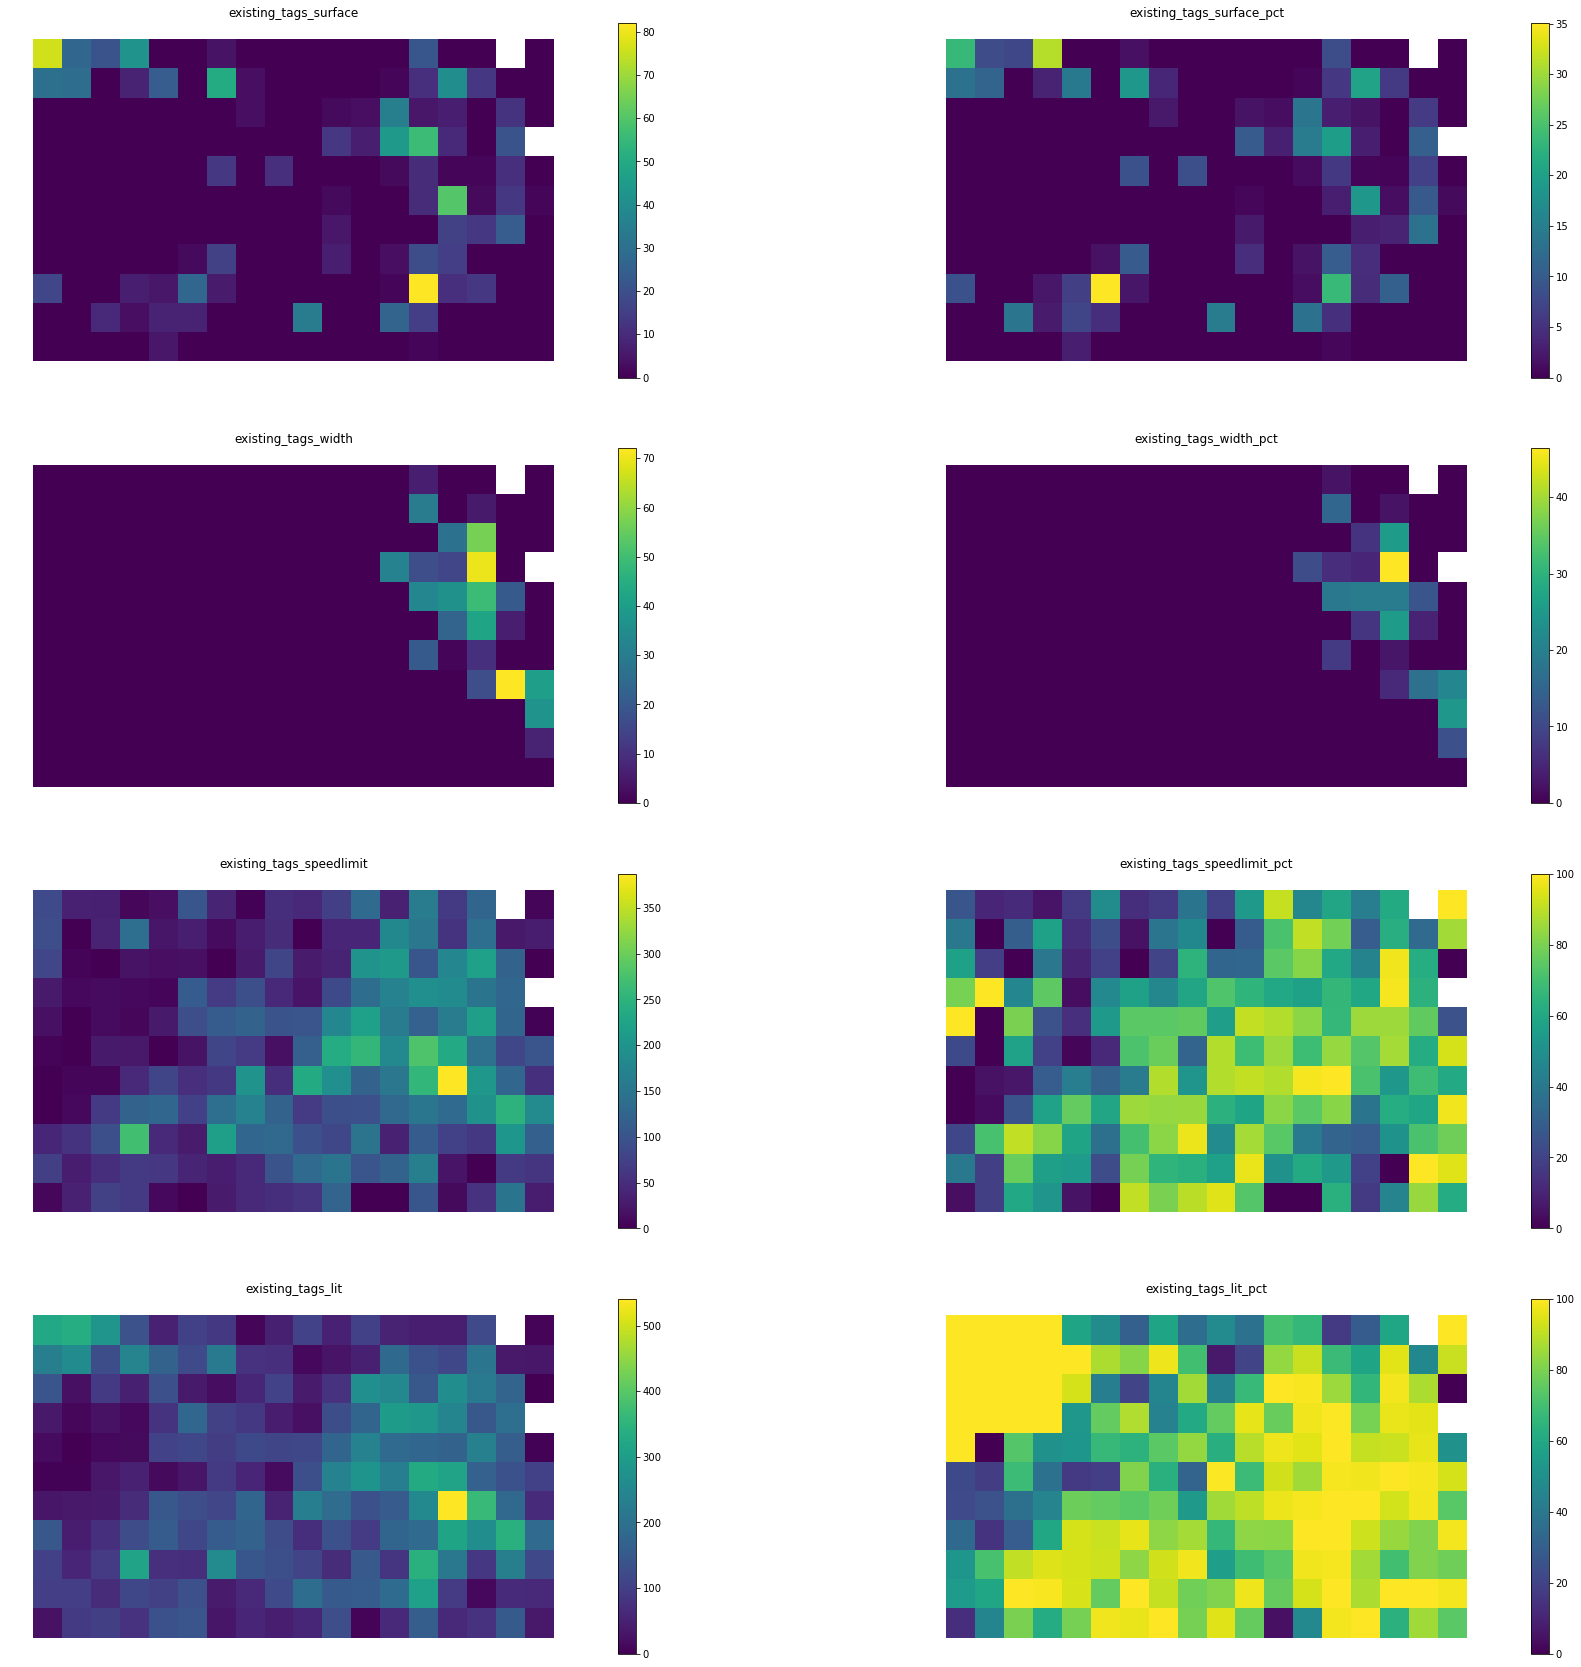

In [47]:
#  TODO: Format plotting 
fig, axes = plt.subplots(nrows=len(new_cols), ncols=2, figsize=(30,30))

for i,c in enumerate(new_cols):
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    grid.plot(ax=ax1, column=c, legend=True)
    grid.plot(ax=ax2, column=c+'_pct', legend=True)

    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.set_title(c)
    ax2.set_title(c+'_pct')

### Tag Consistency

**Checking for incompatible tags:**

In [48]:
incompatible_tags_results = ef.check_incompatible_tags(edges, incompatible_tags_dict)

print(f'In the entire dataset, there are {sum(incompatible_tags_results.values())} incompatible tag combinations (of those defined)')

results_dict = {}
[ef.run_grid_analysis(grid_id, edges_join, results_dict, ef.check_incompatible_tags, incompatible_tags_dict) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')

cols = results_df.columns
new_cols = ['incompatible_tags_'+c for c in cols]
results_df.columns = new_cols
results_df['incompatible_tags_sum'] = results_df[new_cols].sum(axis=1)
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)
grid = grid.merge(results_df, on='grid_id', how='left')


In the entire dataset, there are 4 incompatible tag combinations (of those defined)


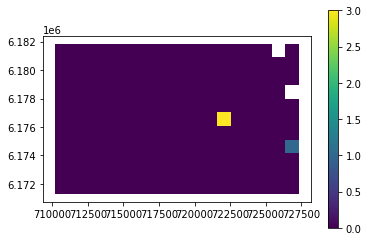

In [49]:
# # TODO: Format plotting -
for key in incompatible_tags_results.keys():
    grid.plot(column='incompatible_tags_'+key, legend=True)

### Visualising tagging of cycling infrastructure

Identifying cycling infrastructuer in OSM can sometimes be complicated, due to the many different ways in which the presence of cycling infrastructure can be indicated. Regardless of how the cycling infrastructure is defined, examining which tags contribute to which parts of the cycling network can be a useful way of visually examining patterns in tagging methods, and whether some elements of the query results in too many or too few features to be included.

Likewise, 'double tagging' where several differnet tags have been used to indicate cycling infrastructure can lead to mis-classifications of the data. In some instances, such as 'cycleway:right' and 'cycleway:left', having data for both tags is valid, but other combinations such as 'cycleway'='track' and 'cycleway:left'=lane gives an ambiguouos picture of what type of cycling infrastructure is present. For this reason, identifying features that are included in more than one of the queries defining cycling infrastructure can indicate issues with the tagging quality.

**OBS! Include here - reference to paper saying you should be clear about how you have retrieved data.**

**Tagging patterns for cycling infrastructure in OSM:**

In [50]:
edges['tagging_type'] = ''

for k, q in cycling_infrastructure_queries.items():

    try:
        ox_filtered = edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)
    
    edges.loc[ox_filtered.index, 'tagging_type'] = edges.loc[ox_filtered.index, 'tagging_type'].astype(str) + str(k)

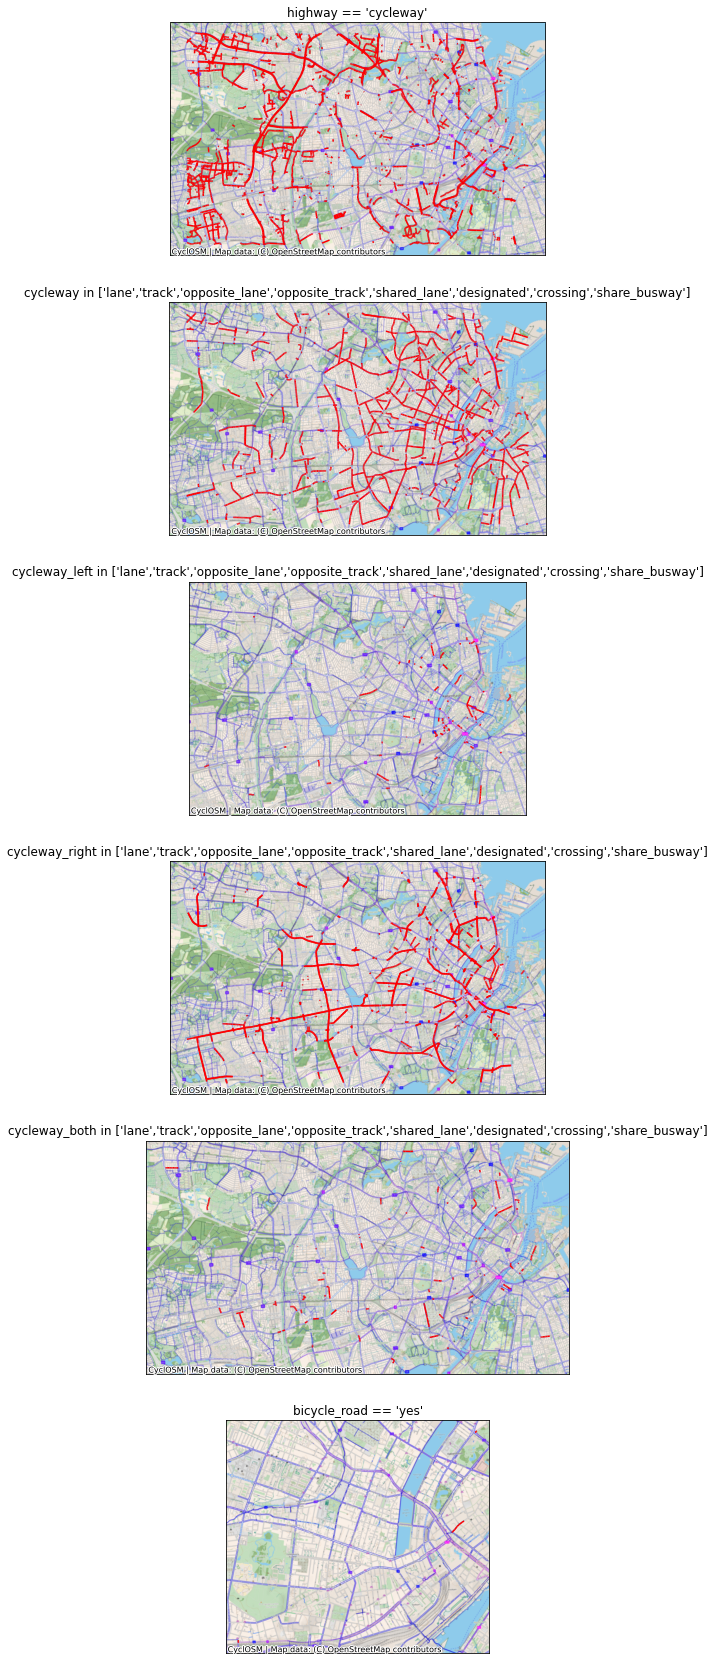

In [51]:
# TODO: fix plots!

# These plots include all edges where the query is true - also those that are true for more than one query
fig, axes = plt.subplots(nrows=len(cycling_infrastructure_queries), ncols=1, figsize=(30,30))

axes = axes.flatten()

for k, q in cycling_infrastructure_queries.items():
    
    ax = axes[k-1]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    edges.loc[edges['tagging_type'].str.contains(str(k))].plot(ax=ax, color='red')

    ax.set_title(q)

    cx.add_basemap(
        ax=ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CyclOSM,
    )

**Visualise where the same type of infrastructure have been tagged using different methods:**

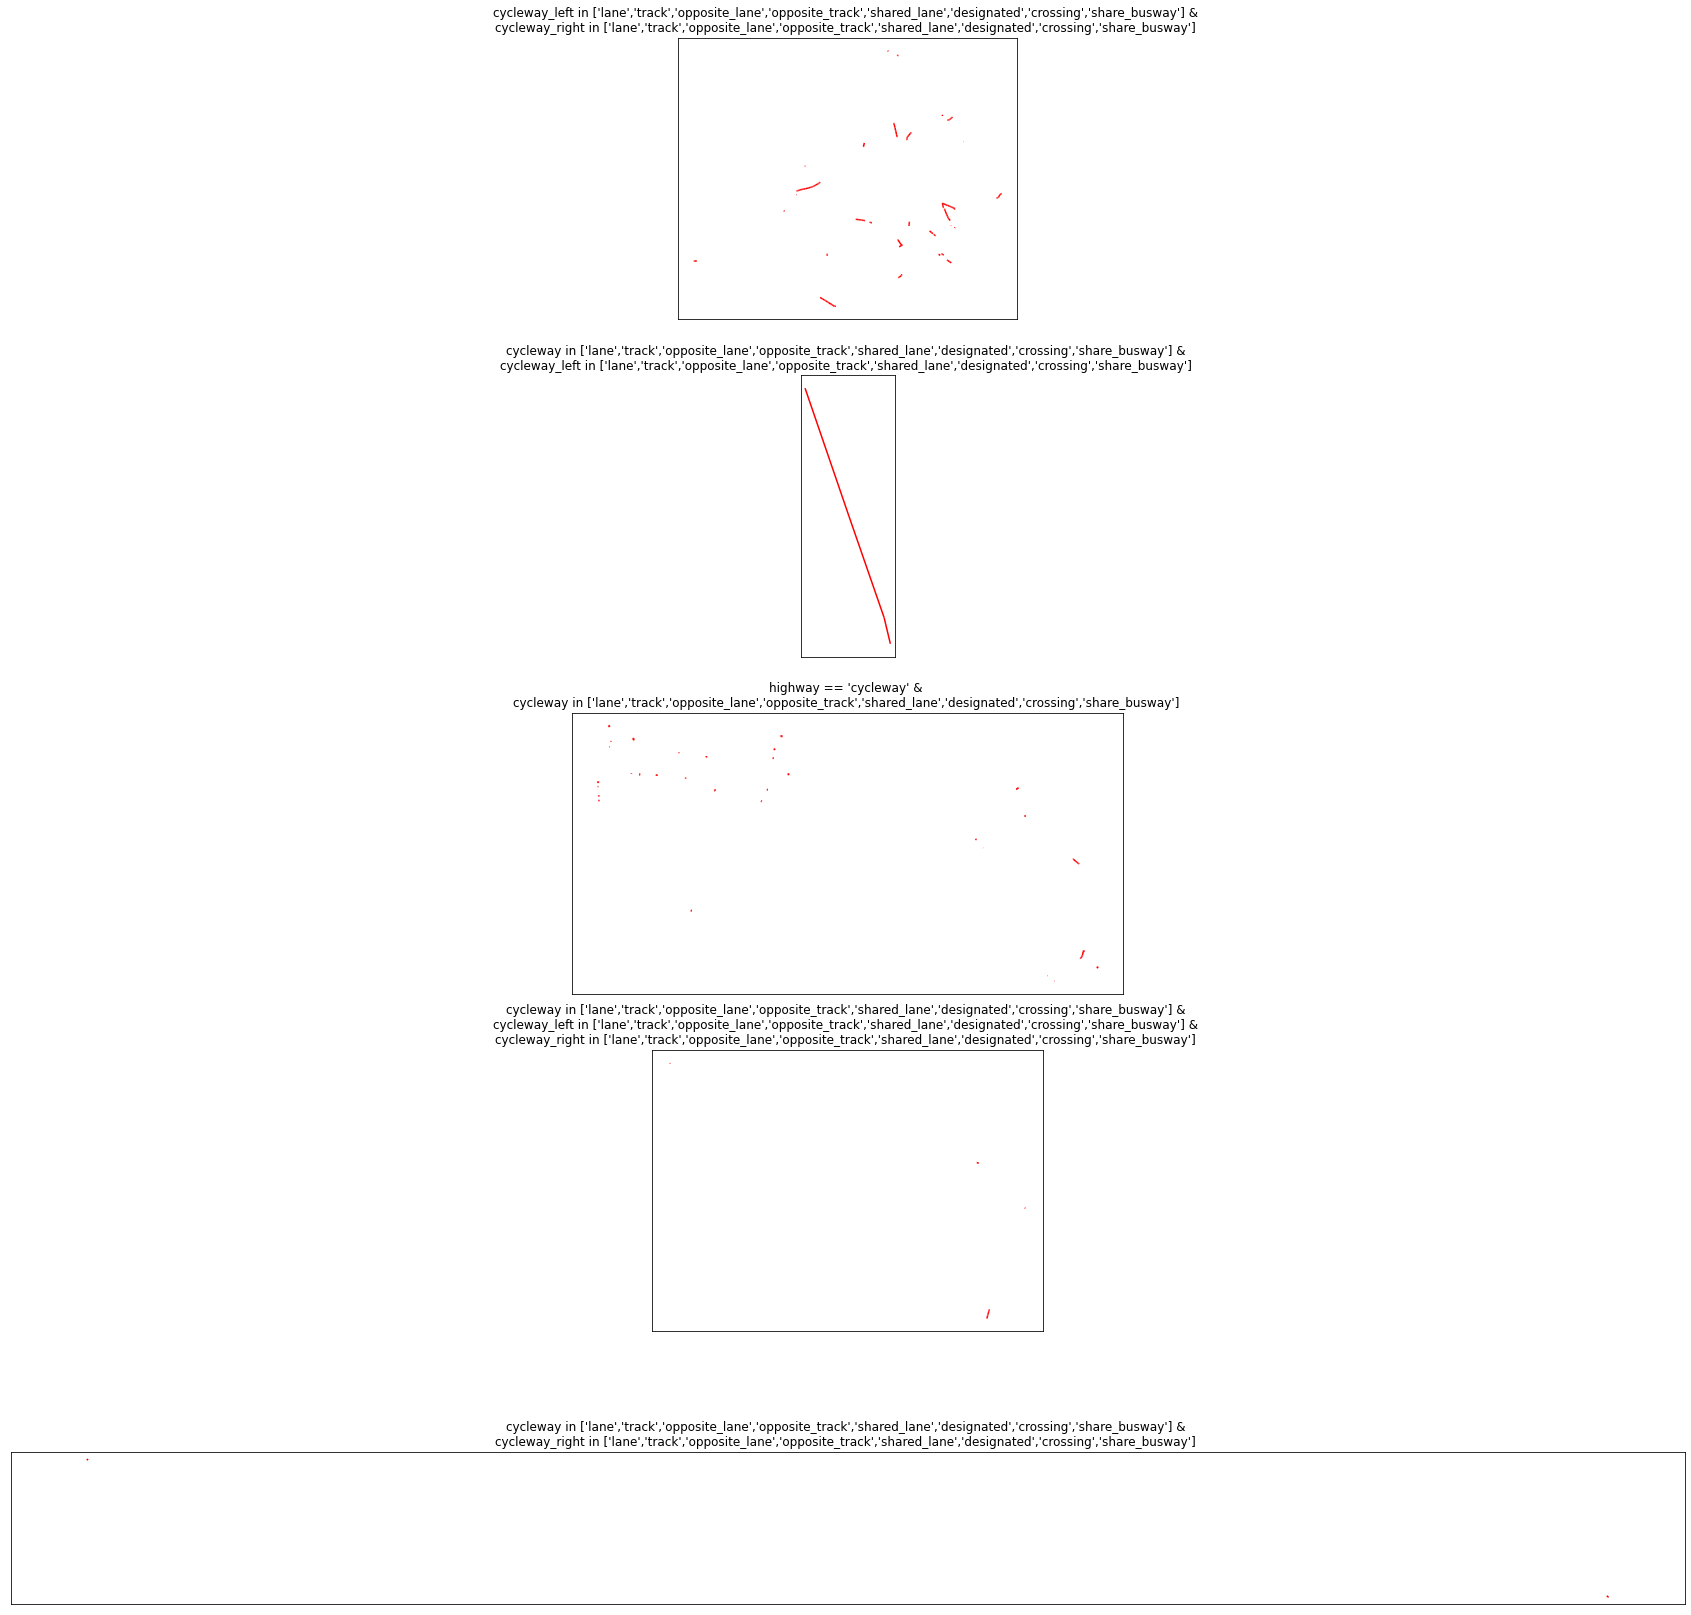

In [52]:
# TODO: fix plots!

# Plot all edges where tagging_type is more than one letter
tagging_combinations = list(edges.tagging_type.unique())
tagging_combinations = [x for x in tagging_combinations if len(x) > 1]

fig, axes = plt.subplots(nrows=len(tagging_combinations), ncols=1, figsize=(30,30))

axes = axes.flatten()

for i, t in enumerate(tagging_combinations):

    ax = axes[i]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    edges.loc[edges['tagging_type']==t].plot(ax=ax, color='red')

    # Get queries corresponding to k
    title = ''
    for value in t:
        query = cycling_infrastructure_queries[int(value)]
        title = title + str(query) + ' & \n'
    
    title = title.rsplit('&', 1)[0]
    
    ax.set_title(title)


## Network Topology

### Network Metrics

**Compute network density:**

Network density without comparing to a reference dataset does not in itself indicate spatial data quality. For anyone familiar with the study area, can however indicate whether parts of the area appear to be under- or overmapped, and is thus included here.

For the entire study area, there are 5826.382894310755 meters of cycling infrastructure per 181.38482884898988 km
For the entire study area, there are 25.12889324274588 nodes in the cycling network per 181.38482884898988 km
For the entire study area, there are 9.802363357964497 dangling nodes in the cycling network per 181.38482884898988 km


<AxesSubplot:>

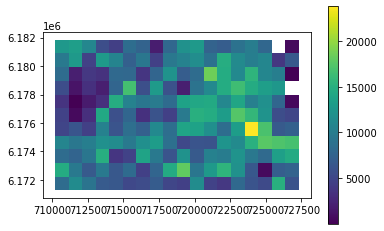

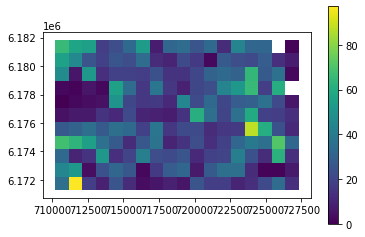

In [53]:
# Entire study area
edge_density, node_density, dangling_node_density = ef.compute_network_density((simplified_edges, simplified_nodes),grid.unary_union.area, return_dangling_nodes=True)

density_results = {}
density_results['edge_density'] = edge_density
density_results['node_density'] = edge_density
density_results['danling_node_density'] = dangling_node_density

# TODO Verify the values!
print(f'For the entire study area, there are {edge_density} meters of cycling infrastructure per {grid.unary_union.area/1000000} km')
print(f'For the entire study area, there are {node_density} nodes in the cycling network per {grid.unary_union.area/1000000} km')
print(f'For the entire study area, there are {dangling_node_density} dangling nodes in the cycling network per {grid.unary_union.area/1000000} km')

# Per grid cell
results_dict = {}
area = grid.loc[0,'geometry'].area
data = (s_edges_join, s_nodes_join)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'edge_density',1:'node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='edge_density', legend=True)
grid.plot(column='node_density', legend=True)

**Count and plot all dangling nodes (dead ends):**

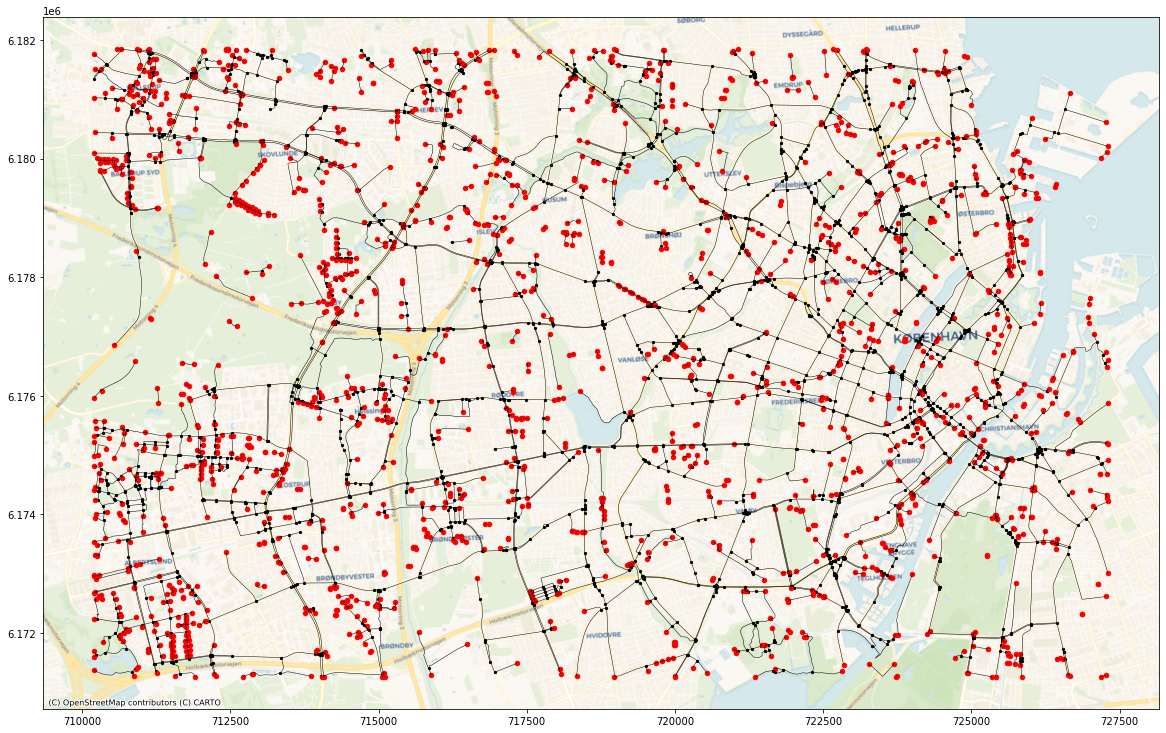

In [54]:
# Compute number of dangling nodes - and plot them
dangling_nodes = ef.get_dangling_nodes(simplified_edges, simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
simplified_nodes.plot(ax=ax, color='black', markersize=5)
dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

### Signs of topological errors

**Count and plot the number of connected components:**

The network in the study area consists of 333 unconnected components.


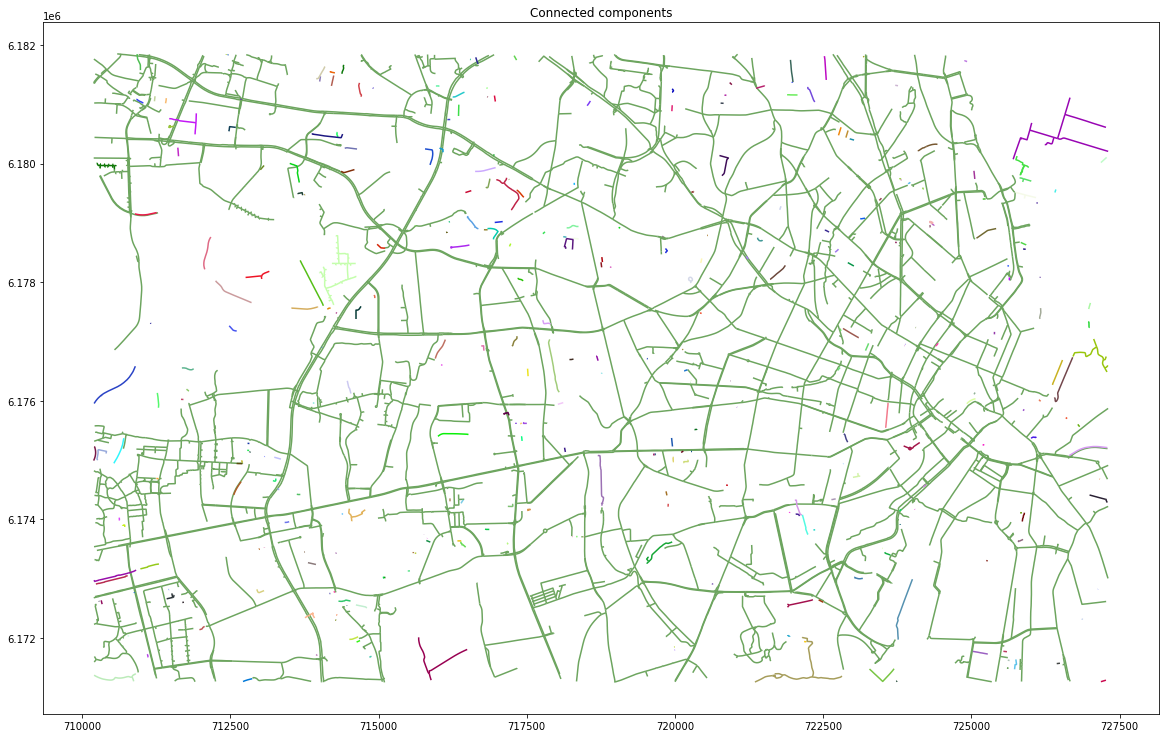

In [55]:
components = ef.return_components(osm_simplified_graph)
print(f'The network in the study area consists of {len(components)} unconnected components.')

components_plot = ef.plot_components(components)

**Distribution of network length per component:**

In [56]:
components_length = {}

for i, c in enumerate(components):

    c_length = 0

    for (u, v, l) in c.edges(data='length'):

        c_length += l
        
    components_length[i] = c_length

components_df = pd.DataFrame.from_dict(components_length, orient='index')

components_df.rename(columns={0:'component_length'}, inplace=True)


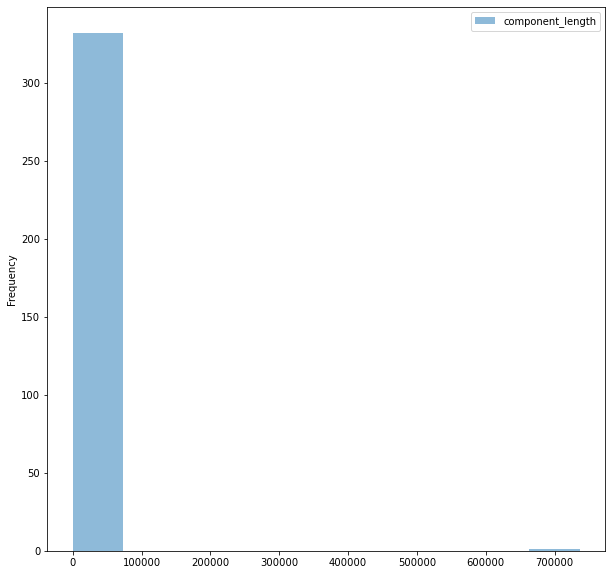

In [57]:
ax = components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (10,10))

# TODO: Format plot. Convert axes to km


In [15]:
largest_cc = max(components, key=len)

largest_cc_length = 0

for (u, v, l) in largest_cc.edges(data='length'):

        largest_cc_length += l

largest_cc_pct = largest_cc_length / components_df['component_length'].sum() * 100

print(f'The largest connected component contains {largest_cc_pct:.2f} % of the network length.')

The largest connected component contains 92.33 % of the network length.


**Identifying unconnected components with less than ten meters between them:**

<AxesSubplot:>

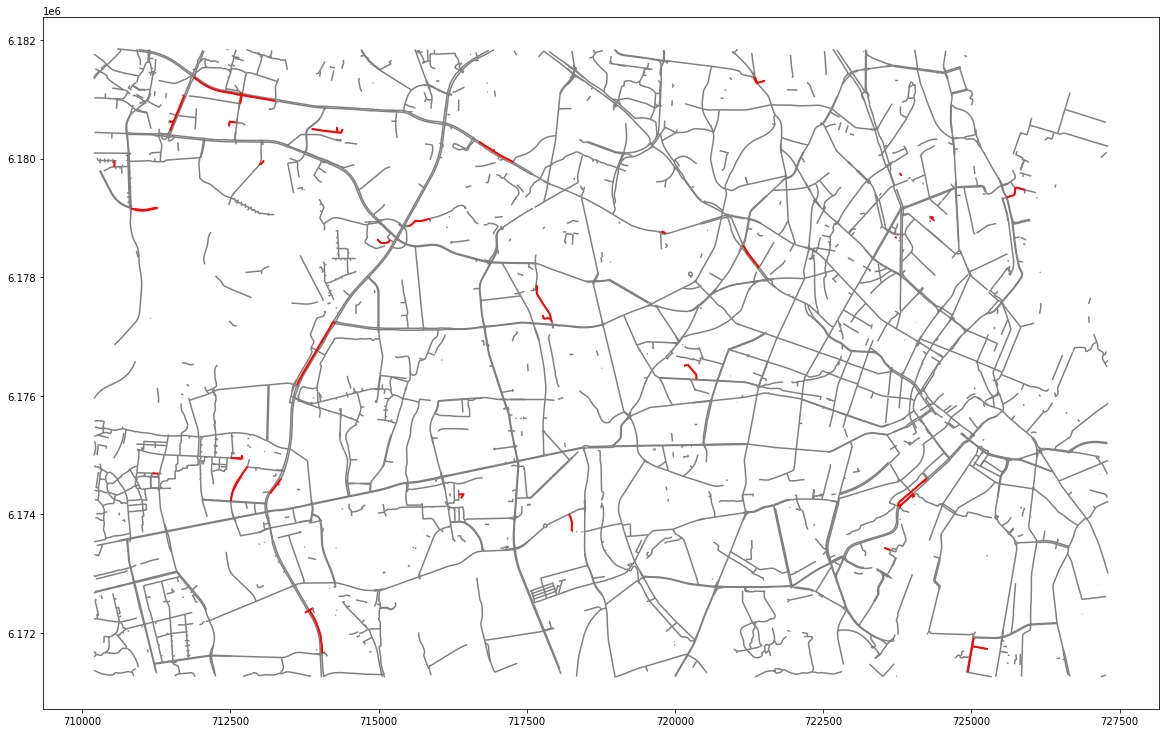

In [40]:
component_issues, component_edges = ef.find_adjacent_components(components=components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

simplified_edges.plot(ax=ax, color='grey')
component_issues.plot(ax=ax, color='red', linewidth=2)

# TODO: Fix plot - plot with uconnected components as well

In [58]:
components_results = {}
components_results['component_count'] = len(components)
components_results['largest_cc_pct_size'] = largest_cc_pct
components_results['largest_cc_pct_length'] = largest_cc_length
components_results['count_adjacent_issues'] = len(component_issues)

**Identifying nodes that are placed within a distance of one meter, but do not share a common edge.**

Based on Barron et al., 2013.


In [ ]:
buffer_dist = 4
osm_snapping_issues = ef.find_network_gaps(simplified_nodes, simplified_edges, buffer_dist)

print(f'For the OSM data, there are {len(osm_snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

if len(osm_snapping_issues) > 0:
    osm_snapping_issues_unpacked = [item for sublist in osm_snapping_issues for item in sublist]

    subset = simplified_nodes.loc[simplified_nodes.node_id.isin(osm_snapping_issues_unpacked)]

    subset.plot(figsize=(10,10))

    # cx.add_basemap(
    #     ax=ax, 
    #     crs=osm_simplified_edges.crs, 
    #     source=cx.providers.CartoDB.Voyager,
    # )
# TODO: Fix plot - folium? 

**Finding edges that cross each other without a node indicating an intersection, and which are not tagged as either bridge or tunnel:**

Based on Barron et al., 2013.

In [61]:
edges['intersection_issues'] = edges.apply(lambda x: ef.check_intersection(row = x, gdf=edges), axis=1)

count_intersection_issues = len(edges.loc[(edges.intersection_issues.notna()) & edges.intersection_issues > 0])

print(f'{count_intersection_issues} edges appear to be missing an intersection node or a bridge/tunnel tag.')

0 edges appear to be missing an intersection node or a bridge/tunnel tag.


In [62]:
# TODO: Fix plot
if count_intersection_issues > 0:
    edges.loc[(edges.intersection_issues.notna()) & (edges.intersection_issues > 0)].plot()

In [96]:
# TODO: Save results

all_results = {}

# Add dictionary with results from existing tags count, incompatible tags, count intersection issues, snapping issues, dangling node count, simplification outcome
# components (number of components, size distribution, issues with close unconnected components)

all_results['existing_tags'] = existing_tags_results
all_results['incompatible_tags'] = incompatible_tags_results
all_results['network_density'] = density_results
all_results['count_intersection_issues'] = count_intersection_issues
all_results['snapping_issues'] = osm_snapping_issues
all_results['dangling_node_cout'] = len(dangling_nodes)
all_results['simplification_outcome'] = simplification_results
all_results['component_analysis'] = components_results

with open(f'../data/osm_instrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(all_results, outfile)

# Save grid with results